In [1]:
from google.colab import drive
import pandas as pd
drive.mount('/content/gdrive') # 此處需要登入google帳號
# 獲取授權碼之後輸入即可連動雲端硬碟
data_loc = 'gdrive/Shared drives/DL_Final_Project/captcha/e3-processed/data/'  #change dir to your project folder

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import torch as t
import torchvision as tv

# from alphabet import alphabet
import numpy as np
import torch, os, glob, time
from torchvision import datasets, transforms
from torchvision.utils import save_image

import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.utils
from PIL import Image
from torch.utils.data.sampler import SubsetRandomSampler

Dataset = torch.utils.data.Dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# torch.cuda.set_device(0)


In [61]:
img_names = os.listdir(data_loc)
X = []
Y = []
print("Image numbers:", len(img_names))
for num, img_path in enumerate(img_names):
    if num%100==0:
        print("image", num)
    img = np.array(Image.open(data_loc+img_path))
    left = img.shape[1]
    right = 0
    for j in range(0, img.shape[0], 10):
        for i in range(img.shape[1]):
            if img[j][i].sum() > 300:
                if i < left:
                    left = i
                break
        for i in range(img.shape[1]-1, 0, -1):
            if img[j][i].sum() > 300:
                if i > right:
                    right = i
                break

    top = img.shape[0]
    bottom = 0
    for j in range(0, img.shape[1], 10):
        for i in range(img.shape[0]):
            if img[i][j].sum() > 300:
                if i < top:
                    top = i
                break
        for i in range(img.shape[0]-1, 0, -1):
            if img[i][j].sum() > 300:
                if i > bottom:
                    bottom = i
                break
    # print(left, right)
    dis = (right - left) // 4
    X.append(img[top:bottom,left:left+dis])
    X.append(img[top:bottom,left+dis:left+dis*2])
    X.append(img[top:bottom,left+dis*2:left+dis*3])
    X.append(img[top:bottom,left+dis*3:right])
    Y.append(int(img_path[0]))
    Y.append(int(img_path[1]))
    Y.append(int(img_path[2]))
    Y.append(int(img_path[3]))

Image numbers: 2942
image 0
image 100
image 200
image 300
image 400
image 500
image 600
image 700
image 800
image 900
image 1000
image 1100
image 1200
image 1300
image 1400
image 1500
image 1600
image 1700
image 1800
image 1900
image 2000
image 2100
image 2200
image 2300
image 2400
image 2500
image 2600
image 2700
image 2800
image 2900


In [0]:
np.save('X.npy',X)
np.save('Y.npy',Y)


In [63]:
Y[:5]

[2, 6, 3, 0, 7]

In [0]:
X = np.load('X.npy', allow_pickle=True)
X = X.tolist()
Y = np.load('Y.npy', allow_pickle=True)
Y = Y.tolist()

In [0]:
import cv2
for i in range(len(X)):
    X[i] = cv2.resize(X[i], (24, 24)).transpose((2, 0, 1))

In [0]:
# #自己寫ImageFolder

# class CaptchaData(Dataset):
#   def __init__(self, data_path, num_class=36, num_char=4, 
# 	             transform=None, target_transform=None):
# 	    super(Dataset, self).__init__()
# 	    self.data_path = data_path
# 	    self.num_class = num_class
# 	    self.num_char = num_char
# 	    self.transform = transform
# 	    self.target_transform = target_transform
# 	    # self.alphabet = alphabet
# 	    self.samples = make_dataset(self.data_path, self.num_class, self.num_char)
     
#   def __len__(self):
#       return len(self.samples)
      
#   def __getitem__(self, index):
#       img_path, target = self.samples[index]
#       img = img_loader(img_path)
#       if self.transform is not None:
#         img = self.transform(img)
#       if self.target_transform is not None:
#         target = self.target_transform(target)

#       return torch.Tensor(np.array(img).reshape((-1))), torch.Tensor(target)




# def img_loader(img_path):
#     img = Image.open(img_path)
#     return img.convert('RGB')
#     # return img.convert('F')


# # make_dataset为读取图片路径和标签的函数, 返回[(img_path, target), (img_path, target), ...]的数据形式
# alphabets = {'a' : 0, 'b': 1, 'c':2, 'd':3, 'e':4, 'f':5, 'g':6, 'h':7, 'i':8, 'j':9, 'k':10, 'l':11, 'm':12, 'n':13, 'o':14,
#              'p': 15, 'q':16,'r':17, 's':18, 't':19, 'u':20, 'v':21, 'w':22, 'x':23, 'y':24, 'z': 25, '0':26, '1':27, '2':28, '3':29, 
#              '4':30, '5':31, '6':32, '7':33, '8':34, '9':35}

# def make_dataset(data_path, num_class, num_char):
#     img_names = os.listdir(data_path)
#     # print(img_names)
#     samples = []
#     count=0
#     for img_name in img_names:
#         # print('img_name:',img_name)
#         img_path = os.path.join(data_path, img_name)
#         # print('img_path:', img_path)
#         #true ans是檔名前面的數字
#         target_str = img_name.split('.')[0]
#         # print('target_str:', target_str)
#         if (target_str.find('(') != -1): 
#             print('delete:',target_str)
#             # os.remove(path + '/' + img_name)
#         else:   
#             count+=1        
#             target = []
#             for char in target_str:
#                 # print('char:', char)
#                 # print(num_class.squeeze(0).transpose((1, 2, 0)))
#                 vec = [0] * 36
#                 vec[alphabets[char]] = 1
#                 target += vec
#             samples.append((img_path, target))

#     print("count:",count)
#     return samples  

In [0]:
# 超参数

BATCH_SIZE = 100

# transform = transforms.Compose([transforms.ToTensor()])

testing_split = .2
test_split = int(np.floor(testing_split * len(X)))

testing_data_x = torch.Tensor(X[:test_split])
testing_data_y = torch.Tensor(Y[:test_split])
training_data_x = torch.Tensor(X[test_split:])
training_data_y = torch.Tensor(Y[test_split:])

training_dataset = Data.TensorDataset(training_data_x, training_data_y)
testing_dataset = Data.TensorDataset(testing_data_x, testing_data_y)
validation_split = .2

dataset_size = len(training_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)



In [67]:
train_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=BATCH_SIZE, num_workers=0, 
                        drop_last=True, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=BATCH_SIZE, num_workers=0, 
                        drop_last=True, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(dataset=testing_dataset, batch_size=BATCH_SIZE, num_workers=0, 
                        drop_last=True, shuffle=False)

print('done')

done


In [68]:
len(training_dataset)

9415

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


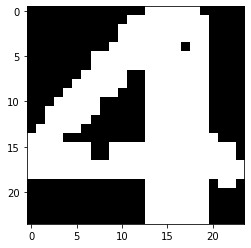

In [69]:
plt.imshow(training_dataset[8][0].cpu().numpy().transpose((1,2,0)))
img = training_dataset[8][0].cpu().numpy().transpose((1,2,0))

In [0]:


BATCH_SIZE = 100

class DNN(t.nn.Module):
      def __init__(self):
          super().__init__()
          # self.num_class = num_class
          # self.num_char = num_char
          self.dnn = t.nn.Sequential(
                t.nn.Linear(24*24*3, 64),
                t.nn.ReLU(),
                nn.Linear(64, 128),
                t.nn.Dropout(0.5),
                t.nn.ReLU(),
                nn.Linear(128, 512),
                t.nn.Dropout(0.5),
                t.nn.ReLU(),
                nn.Linear(512, 128),
                t.nn.Dropout(0.5),
                t.nn.ReLU(),
                nn.Linear(128, 64),
                t.nn.ReLU(),
                nn.Linear(64, 10)
            )


        
      def forward(self,x):

          nn1 = x.view(-1,24*24*3)
          #print(nn1.shape)
          out = self.dnn(nn1)
          #print(out.shape)
          return F.log_softmax(out, dim=1)
          # torch.argmax(out, dim=1)


class Model():
    
    def __init__(self, net, train_data , valid_data , test_data, EPOCH=10, LR=0.0001):
        self.net = net
        # self.num_class = num_class
        # self.num_char = num_char
        self.lr = 0.001
        self.loss = t.nn.CrossEntropyLoss()
        # self.opt = t.optim.SGD(net.parameters(), lr = self.lr, momentum = args.momentum)
        self.opt = t.optim.Adam(net.parameters(), lr = self.lr) 
        self.train_loader = train_data
        self.valid_loader = valid_data
        self.test_loader = test_data
        self.Epoch = EPOCH
        self.LR_ = LR
  

    # 一個一個字看
    def train(self):
        history_loss = []
        history_train_acc = []
        history_valid_acc = []
        EPOCH = 500
        for epoch in range(EPOCH):
            self.net.to(device)  
            self.net.train()
            print('Epoch:', epoch)
            train_loss = 0
            train_correct = 0
            train_total = 0
            for step, (b_x, b_y) in enumerate(train_loader):   # 分配 batch data, normalize x when iterate train_loader
                #print(step)
                b_x, b_y = b_x.to(device), b_y.to(device)
                out = self.net(b_x.view(-1, 24*24*3))   
                # print('out:', len(out), 'b_y:', len(b_y))            # cnn output
                losses = self.loss(out,b_y.long())    # cross entropy loss
                self.opt.zero_grad()
                losses.backward()
                self.opt.step()  

                # apply gradients
                train_loss += losses.item()
                # predicted = output
                _, predicted = out.max(1)
                train_total += b_y.size(0)
                # train_correct += calculat_acc(predicted,b_y)
                train_correct += predicted.eq(b_y).sum().item()
            history_loss.append(train_loss/len(train_loader))
            history_train_acc.append(train_correct/train_total)
            print('【Training】Loss: %.6f | Acc: %.3f%% (%d/%d)' % ( train_loss/len(train_loader.dataset), 100.*(train_correct/train_total), train_correct, train_total ))

            with torch.no_grad():
                valid_loss = 0
                valid_correct = 0
                valid_total = 0
                for step, (b_x, b_y) in enumerate(valid_loader):   # 分配 batch data, normalize x when iterate train_loader
                    b_x, b_y = b_x.to(device), b_y.to(device)
                    out = self.net(b_x.view(-1, 24*24*3))               # cnn output
                    
                    
                    losses = self.loss(out,b_y.long())    # cross entropy loss
                    self.opt.zero_grad()           # clear gradients for this training step

                    valid_loss += losses.item()
                    _, predicted = out.max(1)
                    valid_total += b_y.size(0)
                    # test_correct += calculat_acc(predicted,b_y)
                    valid_correct += predicted.eq(b_y).sum().item()
            history_valid_acc.append((valid_correct/valid_total))
            print('【validation】Loss: %.6f | Acc: %.3f%% (%d/%d)' % ( valid_loss/len(valid_loader), 100.*(valid_correct/valid_total), valid_correct, valid_total ))

        return history_valid_acc, history_train_acc, history_loss

    def get_train_acc(self):

        history_valid_acc, history_train_acc, history_loss = self.train()

        return history_valid_acc, history_train_acc, history_loss

    def get_test_acc(self):

        history_test_acc = self.test()

        return history_test_acc


    def calculat_acc(output, target):
        """ output, target = output.view(-1, 10), target.view(-1, 10)
        output = nn.functional.softmax(output, dim=1)
        output = torch.argmax(output, dim=1)
        target = torch.argmax(target, dim=1)"""
        output, target = output.view(-1, 4), target.view(-1, 4)
        correct_list = []
        for i, j in zip(target, output):
            if torch.equal(i.float(), j.float()):
                correct_list.append(1)
            else:
                correct_list.append(0)
        acc = sum(correct_list)
        return acc






    def test(self):
        history_test_acc = []
        test_loss = 0
        test_correct = 0
        test_total = 0
        for step, (b_x, b_y) in enumerate(test_loader):   # 分配 batch data, normalize x when iterate train_loader
            b_x, b_y = b_x.to(device), b_y.to(device)
            out = self.net(b_x.view(-1, 24*24*3))               # cnn output

            losses = self.loss(out,b_y.long())    # cross entropy loss
            self.opt.zero_grad()           # clear gradients for this training step

            test_loss += losses.item()
            _, predicted = out.max(1)
            test_total += b_y.size(0)
            test_correct += calculat_acc(predicted,b_y)
            # test_correct += predicted.eq(b_y).sum().item()
        history_test_acc.append((test_correct/test_total))
        print('【Testing】Loss: %.4f | Acc: %.2f%% (%d/%d)' % ( test_loss/len(test_loader), (test_correct/((len(test_loader))/4)), test_correct, test_total/4 ))
        return history_test_acc

    #       # t.save(model, './model.pkl')  # 保存整个网络
    #     t.save(self.net.state_dict(), './model_params.pkl')   # 只保存网络中的参数 (速度快, 占内存少)


In [0]:
def calculat_acc(output, target):
    """ output, target = output.view(-1, 10), target.view(-1, 10)
    output = nn.functional.softmax(output, dim=1)
    output = torch.argmax(output, dim=1)
    target = torch.argmax(target, dim=1)"""
    output, target = output.view(-1, 4), target.view(-1, 4)
    correct_list = []
    for i, j in zip(target, output):
        if torch.equal(i.float(), j.float()):
            correct_list.append(1)
        else:
            correct_list.append(0)
    acc = sum(correct_list)
    return acc

In [74]:
dnn_module = Model(DNN(), train_loader, valid_loader, test_loader, EPOCH=50, LR=0.0001)
# train_loss_history, test_acc_history = dnn_module.train()
history_valid_acc, history_train_acc, history_loss = dnn_module.get_train_acc()

Epoch: 0
【Training】Loss: 0.015100 | Acc: 30.627% (2297/7500)
【validation】Loss: 1.449645 | Acc: 45.056% (811/1800)
Epoch: 1
【Training】Loss: 0.009842 | Acc: 54.627% (4097/7500)
【validation】Loss: 1.048529 | Acc: 61.222% (1102/1800)
Epoch: 2
【Training】Loss: 0.007360 | Acc: 63.693% (4777/7500)
【validation】Loss: 0.864724 | Acc: 63.278% (1139/1800)
Epoch: 3
【Training】Loss: 0.006403 | Acc: 63.973% (4798/7500)
【validation】Loss: 0.746211 | Acc: 65.056% (1171/1800)
Epoch: 4
【Training】Loss: 0.005999 | Acc: 65.573% (4918/7500)
【validation】Loss: 0.783610 | Acc: 64.444% (1160/1800)
Epoch: 5
【Training】Loss: 0.005790 | Acc: 65.413% (4906/7500)
【validation】Loss: 0.688909 | Acc: 65.667% (1182/1800)
Epoch: 6
【Training】Loss: 0.005266 | Acc: 67.147% (5036/7500)
【validation】Loss: 0.669867 | Acc: 67.500% (1215/1800)
Epoch: 7
【Training】Loss: 0.005115 | Acc: 67.867% (5090/7500)
【validation】Loss: 0.707009 | Acc: 67.333% (1212/1800)
Epoch: 8
【Training】Loss: 0.005311 | Acc: 66.467% (4985/7500)
【validation】Loss: 0.

In [41]:

history_test_acc = dnn_module.get_test_acc()

NameError: ignored

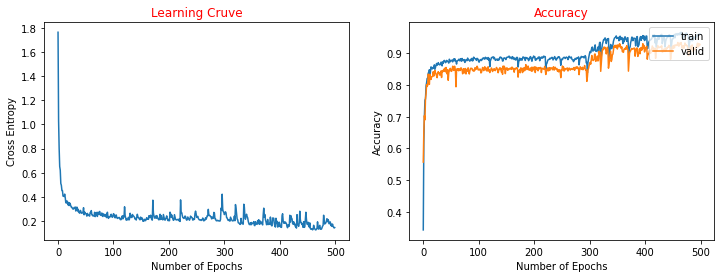

In [32]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
ax[0].set_title('Learning Cruve', color='r')
ax[0].set_xlabel('Number of Epochs')
ax[0].set_ylabel('Cross Entropy')
ax[0].plot(history_loss)

ax[1].set_title('Accuracy', color='r')
ax[1].set_xlabel('Number of Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].plot(history_train_acc, label = 'train')
ax[1].plot(history_valid_acc, label = 'valid')
plt.legend(loc=1)
